In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

## Read Data For WA, NY, TX, CA and from 2018 to 2022

In [2]:
# Navigate up one level from the current directory
parent_dir = os.path.dirname(os.getcwd())

# Define the relative path to the Parquet file from the parent directory
relative_path = r"analyticsDF.parquet"

# Concatenate the parent directory path and the relative path to get the full path
full_path = os.path.join(parent_dir, relative_path)

In [3]:
df = pd.read_parquet(full_path)

In [4]:
#df.info(verbose = True, show_counts=True)

In [5]:
# size of dataset
len(df)

9712778

## Drop rows due to inconclusive dependent variable

In [6]:
# Values:

#     1 - 1 Loan originated
#     2 - 1 Application approved but not accepted
#     3 - 0 Application denied
#     4 - *drop* Application withdrawn by applicant
#     5 - *drop* File closed for incompleteness
#     6 - 1 Purchased loan
#     7 - 0 Preapproval request denied
#     8 - 1 Preapproval request approved but not accepted

selected = df.loc[:, 'action_taken'].isin(['4', '5'])
df = df[~selected]
len(df)

8211413

In [7]:
# Create dependate binary variable

accepted_selected = df.loc[:, 'action_taken'].isin(['1', '2', '6', '8'])
df.loc[:, 'application_approved'] = 0  # Default value is 0

# Update rows where accepted_selected is True
df.loc[accepted_selected, 'application_approved'] = 1

In [8]:
df.application_approved.value_counts()

1    7400743
0     810670
Name: application_approved, dtype: int64

## Cleaning Features

In [9]:
#conbination of race and ethinicty to no leave out hispanic or latino

df['race_ethnicity'] = df['derived_race'].str.cat(df['derived_ethnicity'], sep='|')

# how many categroies were created
len(df.race_ethnicity.value_counts(dropna=False))

45

### Keep Columns of Interest

In [10]:
# Keep columns of interest
df = df.loc[:, ['application_approved', 'race_ethnicity','county_code', 'derived_sex', 'income', 'applicant_age', 'loan_amount', 'property_value', 'loan_term', 'interest_rate', 'state_code', 'activity_year', 'occupancy_type','denial_reasons']]

In [11]:

blank_counts = df.isna().sum()

# Get total number of rows
total_rows = len(df)

# Show summary
print("Summary of blanks per column:")
for column, blank_count in blank_counts.items():
    print(f"{column}: {blank_count}")


Summary of blanks per column:
application_approved: 0
race_ethnicity: 0
county_code: 0
derived_sex: 0
income: 1182053
applicant_age: 0
loan_amount: 0
property_value: 175011
loan_term: 22140
interest_rate: 857499
state_code: 0
activity_year: 0
occupancy_type: 0
denial_reasons: 0


In [12]:
df.columns

Index(['application_approved', 'race_ethnicity', 'county_code', 'derived_sex',
       'income', 'applicant_age', 'loan_amount', 'property_value', 'loan_term',
       'interest_rate', 'state_code', 'activity_year', 'occupancy_type',
       'denial_reasons'],
      dtype='object')

In [13]:
df.application_approved.value_counts()

1    7400743
0     810670
Name: application_approved, dtype: int64

In [14]:
# Remove negative ammounts
#fill any nan values in y with 0
df = df.fillna(0)

df = df[df.loc[:,'income']>=0]

df = df[df.loc[:,'property_value']>=0]
df = df[df['interest_rate']>=0]

df = df[df['loan_term']>=0]
#Normalized Income

# Apply log transformation using numpy's log1p function
df['income_log'] = np.log1p(df['income'])

# Convert the 'loan_amount' column to float64
df['loan_amount'] = df['loan_amount'].astype('float64')

# Apply log transformation using numpy's log1p function
df['loan_amount_log'] = np.log1p(df['loan_amount'])

# Convert the 'loan_amount' column to float64
df['property_value'] = df['property_value'].astype('float64')

# Apply log transformation using numpy's log1p function
df['property_value_log'] = np.log1p(df['property_value'])

df['interest_rate'] = df['interest_rate'].astype('float64')

df['loan_term'] = df['loan_term'].astype('float64')


df['loan_to_value'] = df['loan_amount'] / df['property_value'] 

df['debt_to_income'] = df['loan_amount'] / df['income'] 

df.drop(['income', 'loan_amount', 'property_value', 'denial_reasons'], axis=1, inplace=True) 

# size of dataset
len(df)

8081760

In [27]:
df.replace([np.inf, -np.inf], 0, inplace=True)

In [28]:
df.application_approved.value_counts()

1    7284324
0     797436
Name: application_approved, dtype: int64

In [29]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
application_approved,8081760.0,0.901329,0.298220,0.000000,1.000000,1.000000,1.000000,1.000000e+00
loan_term,8081760.0,341.776303,60.522145,0.000000,360.000000,360.000000,360.000000,3.660000e+03
interest_rate,8081760.0,3.705942,23.659075,0.000000,2.875000,3.750000,4.625000,4.387500e+04
income_log,8081760.0,4.046799,1.846369,0.000000,3.970292,4.521789,5.017280,1.904484e+01
loan_amount_log,8081760.0,12.552089,0.939422,8.517393,12.180760,12.628070,13.091906,2.106665e+01
property_value_log,8081760.0,12.569439,2.017163,0.000000,12.323860,12.807655,13.296318,2.148756e+01
loan_to_value,8081760.0,0.807775,0.684891,0.000000,0.751412,0.860465,0.962264,8.810000e+02
debt_to_income,8081760.0,2806.347677,7362.188524,0.000000,1341.463415,2685.950413,3869.047619,9.213824e+06


In [30]:
def plot_distribution(df):
    """Plot distribution charts for all float columns in the DataFrame.

    Args:
        df (pandas DataFrame): Input DataFrame
    """
    import matplotlib.pyplot as plt
    # Select only float columns
    float_cols = df.select_dtypes(include=['float'])

    # Plot distribution for each float column
    for col in float_cols.columns:
        plt.figure(figsize=(8, 6))
        # Calculate number of bins dynamically
        min_val = df[col].min()
        max_val = df[col].max()
        num_bins = min(10, max_val - min_val)  # Limiting to 20 bins or the range of the data
        plt.hist(df[col], bins=num_bins, range=(min_val, max_val), color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()


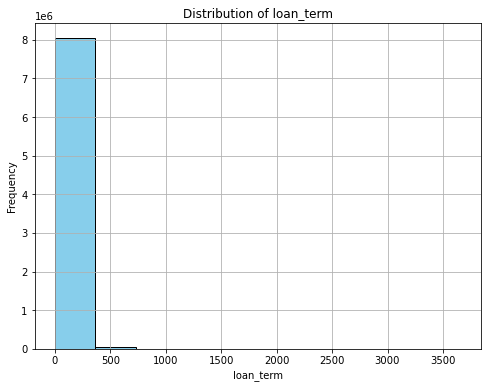

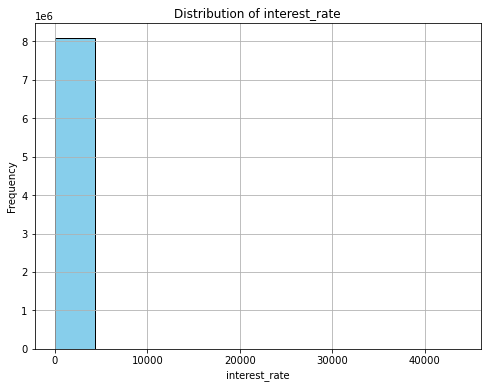

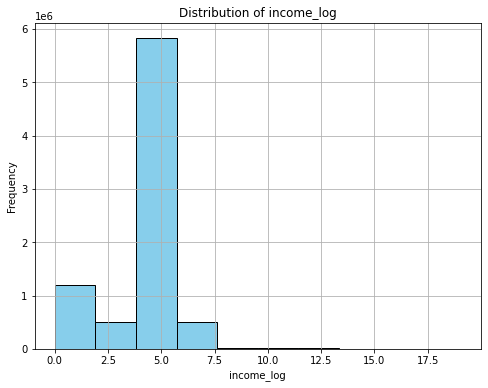

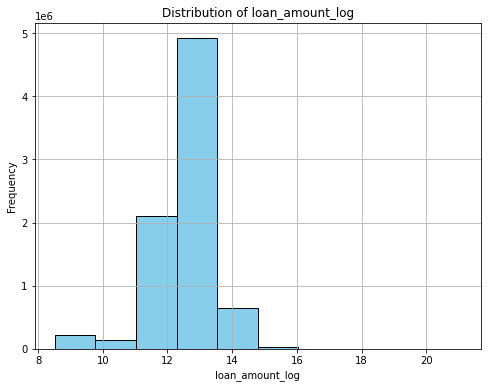

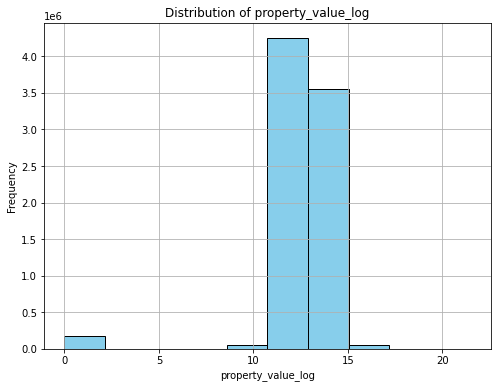

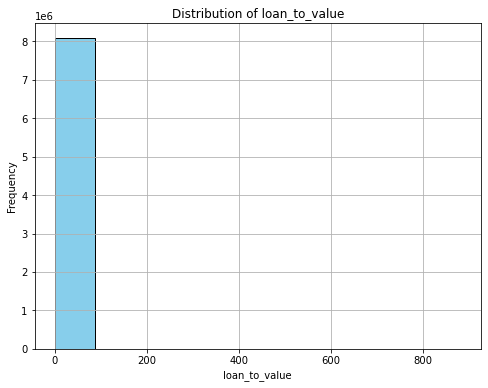

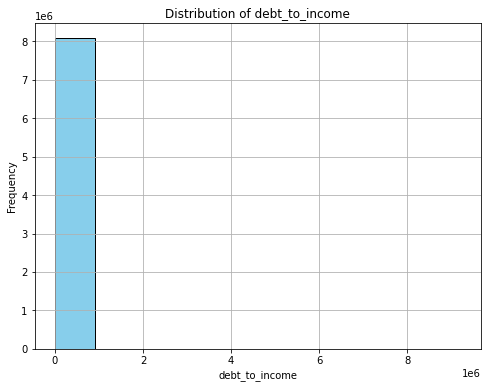

In [31]:
plot_distribution(df)

In [32]:

data_encoded = pd.get_dummies(df, columns=['race_ethnicity', 'state_code', 'activity_year' ,'occupancy_type','county_code', 'derived_sex','applicant_age' ], drop_first=True)


In [33]:
data_encoded_ref = pd.get_dummies(df, columns=['race_ethnicity', 'state_code', 'activity_year' ,'occupancy_type','county_code', 'derived_sex','applicant_age' ], drop_first=False)

In [34]:
len(data_encoded.columns)

587

In [35]:
data_encoded.columns

Index(['application_approved', 'loan_term', 'interest_rate', 'income_log',
       'loan_amount_log', 'property_value_log', 'loan_to_value',
       'debt_to_income',
       'race_ethnicity_2 or more minority races|Free Form Text Only',
       'race_ethnicity_2 or more minority races|Hispanic or Latino',
       ...
       'derived_sex_Male', 'derived_sex_Sex Not Available',
       'applicant_age_25-34', 'applicant_age_35-44', 'applicant_age_45-54',
       'applicant_age_55-64', 'applicant_age_65-74', 'applicant_age_9999',
       'applicant_age_<25', 'applicant_age_>74'],
      dtype='object', length=587)

In [36]:
data_encoded_ref.columns

Index(['application_approved', 'loan_term', 'interest_rate', 'income_log',
       'loan_amount_log', 'property_value_log', 'loan_to_value',
       'debt_to_income',
       'race_ethnicity_2 or more minority races|Ethnicity Not Available',
       'race_ethnicity_2 or more minority races|Free Form Text Only',
       ...
       'derived_sex_Sex Not Available', 'applicant_age_-99',
       'applicant_age_25-34', 'applicant_age_35-44', 'applicant_age_45-54',
       'applicant_age_55-64', 'applicant_age_65-74', 'applicant_age_9999',
       'applicant_age_<25', 'applicant_age_>74'],
      dtype='object', length=594)

In [37]:
# Reference Columns
columns_only_in_df1 = data_encoded_ref.columns.difference(data_encoded.columns)
columns_only_in_df1

Index(['activity_year_2018', 'applicant_age_-99', 'county_code_00037',
       'derived_sex_Female', 'occupancy_type_Investment',
       'race_ethnicity_2 or more minority races|Ethnicity Not Available',
       'state_code_CA'],
      dtype='object')

In [38]:
df.to_parquet(parent_dir + "\df_small.parquet")
data_encoded.to_parquet(parent_dir + "\df_small_encoded.parquet")